# RAPIDS cuML TfidfVectorizer and KNN to find similar Text and Images
In this notebook we use RAPIDS cuML's TfidfVectorizer and cuML's KNN to find items with similar titles and items with similar images. First we use RAPIDS cuML TfidfVectorizer to extract text embeddings of each item's title and then compare the embeddings using RAPIDS cuML KNN. Next we extract image embeddings of each item with EffNetB0 and compare them using RAPIDS cuML KNN.[](http://)

# Load Libraries

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
print('TF',tf.__version__)

In [2]:
# RESTRICT TENSORFLOW TO 12GB OF GPU RAM
# SO THAT WE HAVE GPU RAM FOR RAPIDS CUML KNN
LIMIT = 12
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)
print('Restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('so RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

Restrict TensorFlow to max 12GB GPU RAM
so RAPIDS can use 4GB GPU RAM


2022-05-04 07:15:57.206215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-04 07:15:57.207166: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-04 07:15:57.207288: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib/python3.7/site-packages/cv2/../../lib64:
2022-05-04 07:15:57.207374: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cann

# Load Train Data
In this competition, we have items with an image and title. For the train data, the column `label_group` indicates the ground truth of which items are similar. We need to build a model that finds these similar images based on their image and title's text. In this notebook we explore some tools to help us.

In [3]:
train = pd.read_csv('../input/shopee-product-matching/train.csv')
print('train shape is', train.shape )
train.head()

train shape is (34250, 5)


posting_id                                 image       image_phash  \
0   train_129225211  0000a68812bc7e98c42888dfb1c07da0.jpg  94974f937d4c2433   
1  train_3386243561  00039780dfc94d01db8676fe789ecd05.jpg  af3f9460c2838f0f   
2  train_2288590299  000a190fdd715a2a36faed16e2c65df7.jpg  b94cb00ed3e50f78   
3  train_2406599165  00117e4fc239b1b641ff08340b429633.jpg  8514fc58eafea283   
4  train_3369186413  00136d1cf4edede0203f32f05f660588.jpg  a6f319f924ad708c   

                                               title  label_group  
0                          Paper Bag Victoria Secret    249114794  
1  Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...   2937985045  
2        Maling TTS Canned Pork Luncheon Meat 397 gr   2395904891  
3  Daster Batik Lengan pendek - Motif Acak / Camp...   4093212188  
4                  Nescafe \xc3\x89clair Latte 220ml   3648931069

# Display Random Items from Train Data

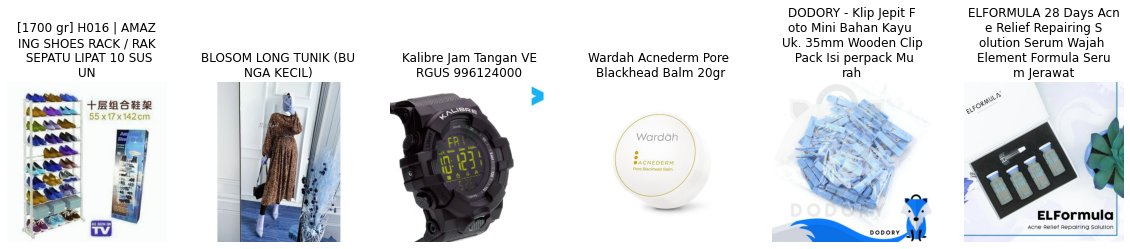

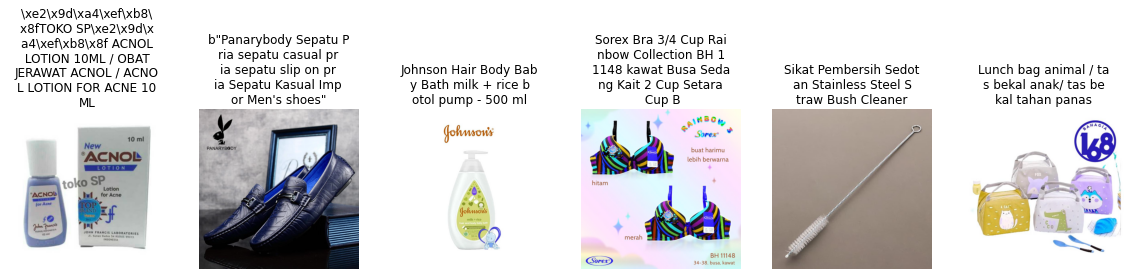

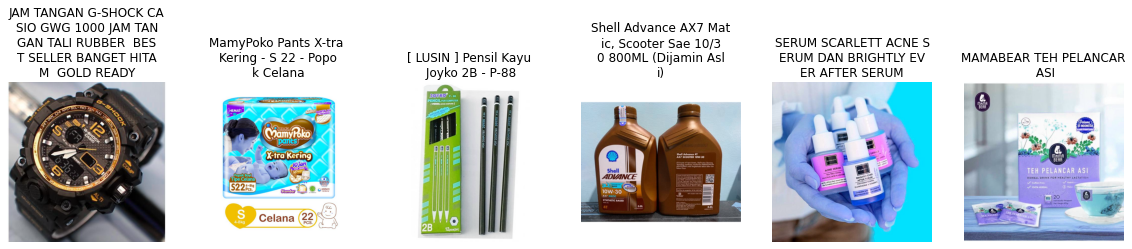

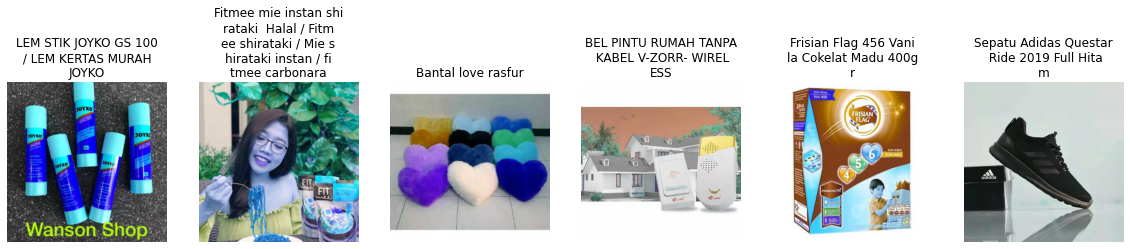

In [4]:
BASE = '../input/shopee-product-matching/train_images/'

def displayDF(train, random=False, COLS=6, ROWS=4, path=BASE):
    for k in range(ROWS):
        plt.figure(figsize=(20,5))
        for j in range(COLS):
            if random: row = np.random.randint(0,len(train))
            else: row = COLS*k + j
            name = train.iloc[row,1]
            title = train.iloc[row,3]
            title_with_return = ""
            for i,ch in enumerate(title):
                title_with_return += ch
                if (i!=0)&(i%20==0): title_with_return += '\n'
            img = cv2.imread(path+name)
            plt.subplot(1,COLS,j+1)
            plt.title(title_with_return)
            plt.axis('off')
            plt.imshow(img)
        plt.show()
        
displayDF(train,random=True)

# Display Duplicated Items from Train Data
Using the column `label_group` which is the ground truth, we can display examples of duplicated items.

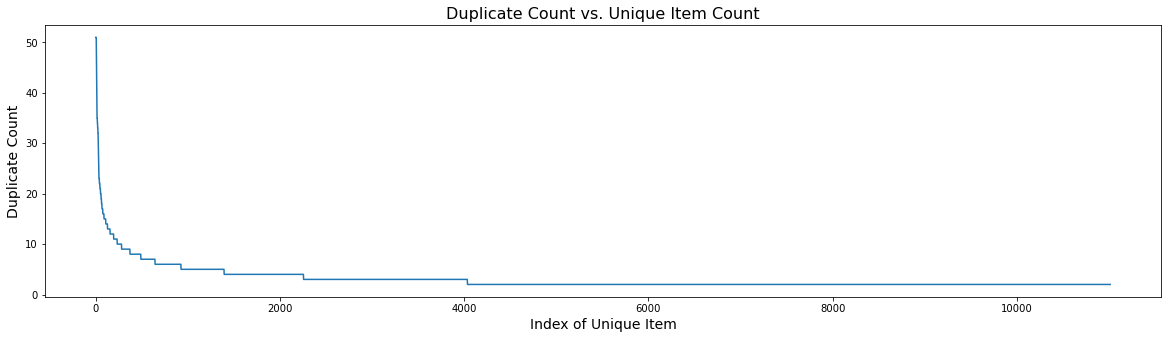

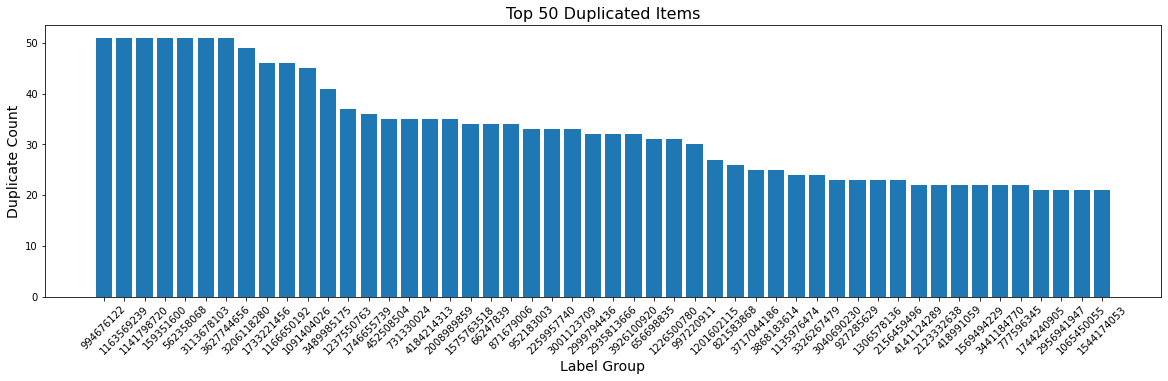

In [5]:
groups = train.label_group.value_counts()
plt.figure(figsize=(20,5))
plt.plot(np.arange(len(groups)),groups.values)
plt.ylabel('Duplicate Count',size=14)
plt.xlabel('Index of Unique Item',size=14)
plt.title('Duplicate Count vs. Unique Item Count',size=16)
plt.show()

plt.figure(figsize=(20,5))
plt.bar(groups.index.values[:50].astype('str'),groups.values[:50])
plt.xticks(rotation = 45)
plt.ylabel('Duplicate Count',size=14)
plt.xlabel('Label Group',size=14)
plt.title('Top 50 Duplicated Items',size=16)
plt.show()

########################################
### TOP 1 DUPLICATED ITEM: 994676122
########################################


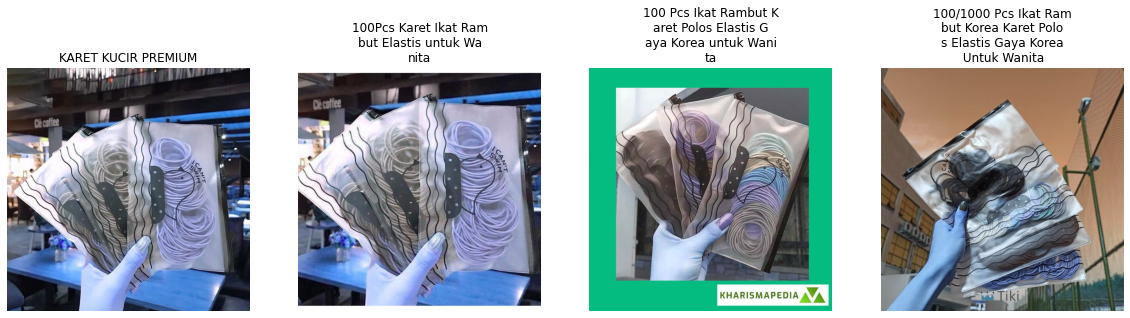

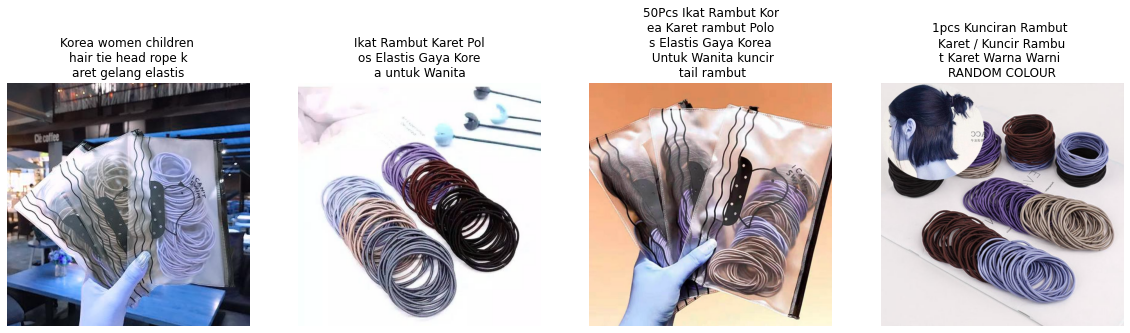

########################################
### TOP 2 DUPLICATED ITEM: 1163569239
########################################


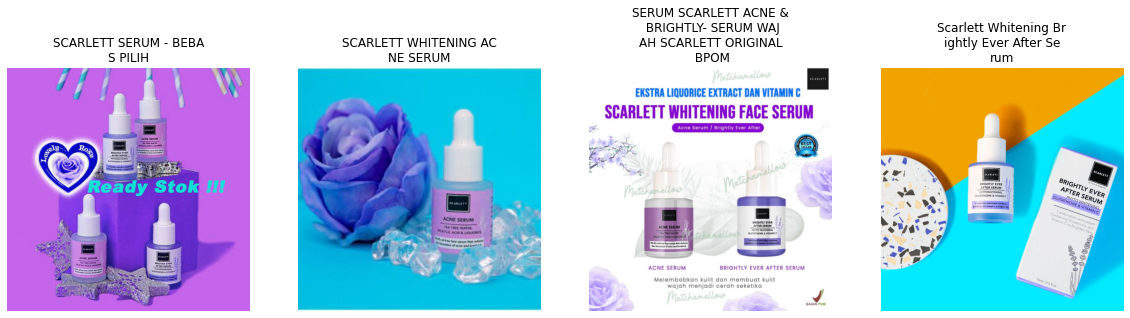

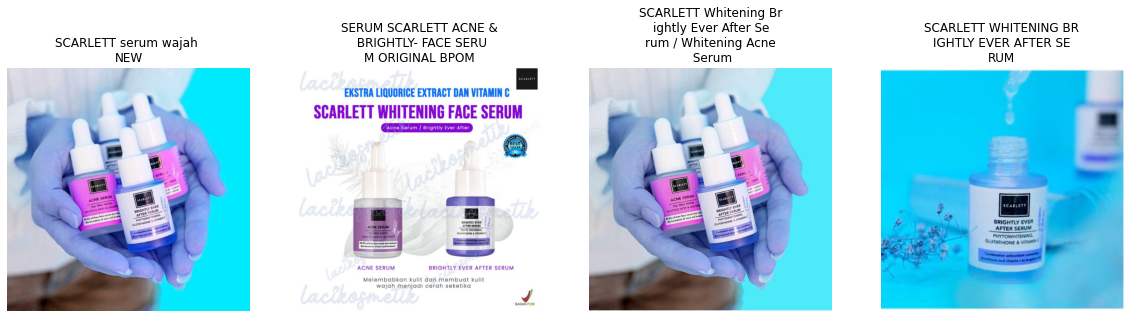

########################################
### TOP 3 DUPLICATED ITEM: 1141798720
########################################


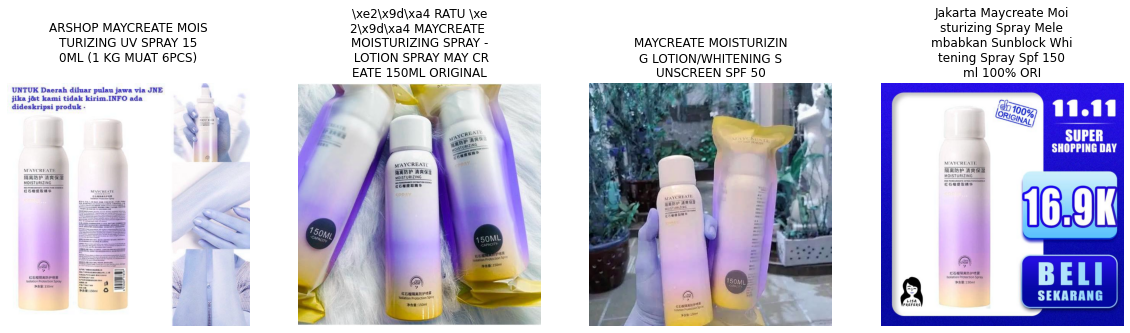

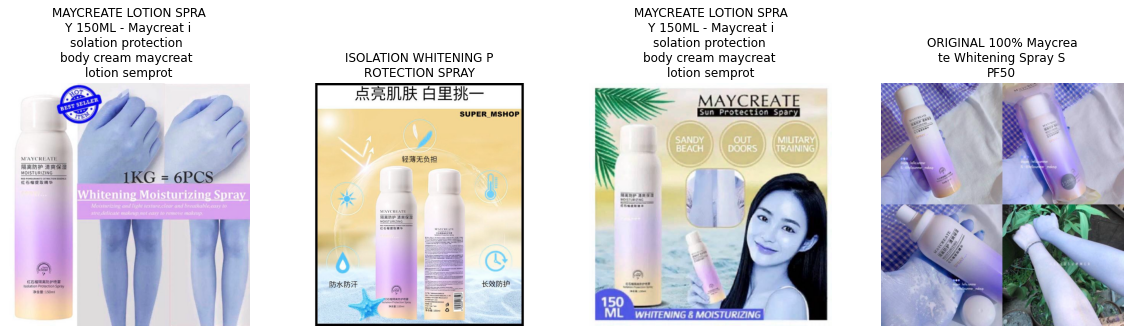

########################################
### TOP 4 DUPLICATED ITEM: 159351600
########################################


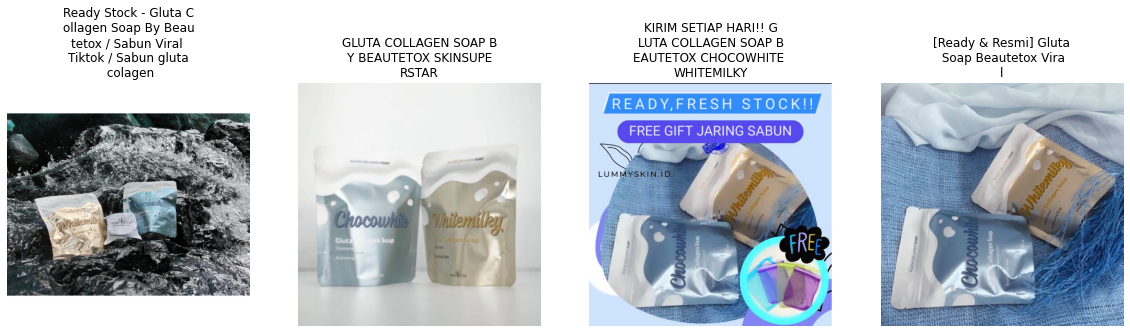

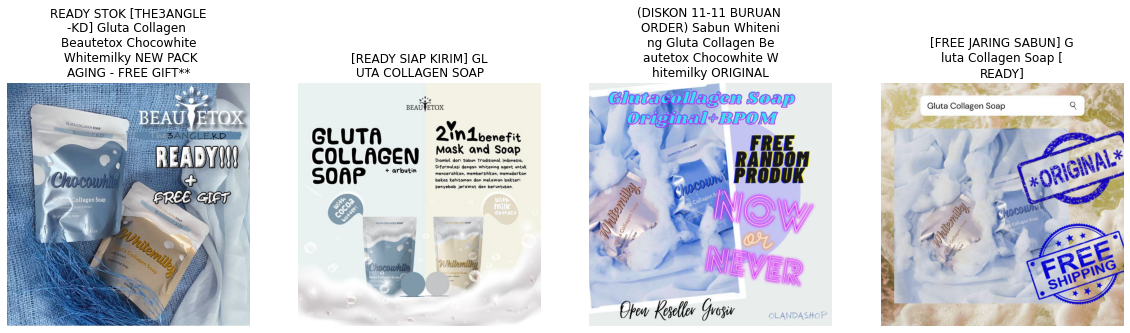

########################################
### TOP 5 DUPLICATED ITEM: 562358068
########################################


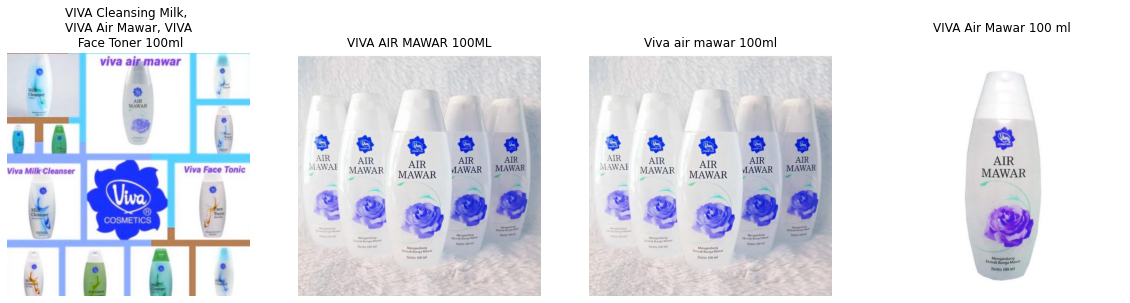

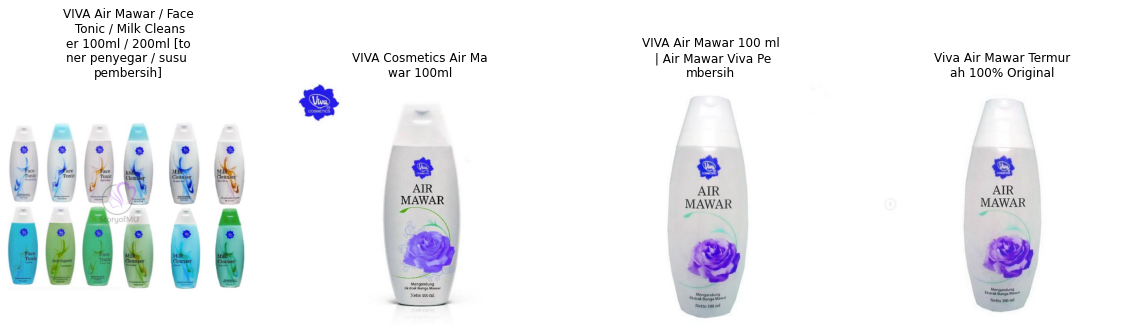

In [6]:
for k in range(5):
    print('#'*40)
    print('### TOP %i DUPLICATED ITEM:'%(k+1),groups.index[k])
    print('#'*40)
    top = train.loc[train.label_group==groups.index[k]]
    displayDF(top, random=False, ROWS=2, COLS=4)

# Find Similar Titles with RAPIDS!
We will now ignore the ground truth and try to find similar items in train data using only the title's text. First we will extract text embeddings using RAPIDS cuML's TfidfVectorizer. This will turn every title into a one-hot-encoding of the words present. We will then compare one-hot-encodings with RAPIDS cuML KNN to find title's that are similar.

In [1]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors
print('RAPIDS',cuml.__version__)

ModuleNotFoundError: No module named 'cudf'

In [2]:
!conda install -c rapidsai -c nvidia -c numba -c conda-forge \
    cudf=21.08 python=3.7 cudatoolkit=11.0


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'rapidsai'


In [ ]:
# LOAD TRAIN UNTO THE GPU WITH CUDF
train_gf = cudf.read_csv('../input/shopee-product-matching/train.csv')
print('train shape is', train_gf.shape )
train_gf.head()

## Extract Text Embeddings with RAPIDS TfidfVectorizer
TfidfVectorizer returns a cupy sparse matrix. Afterward we convert to a cupy dense matrix and feed that into RAPIDS cuML KNN.

In [ ]:
model = TfidfVectorizer(stop_words='english', binary=True)
text_embeddings = model.fit_transform(train_gf.title).toarray()
print('text embeddings shape is',text_embeddings.shape)

## Find Similar Titles with RAPIDS KNN
After fitting KNN, we will display some example rows of train and their 10 closest other titles in train (based on word count one-hot-encoding).

In [ ]:
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(text_embeddings)
distances, indices = model.kneighbors(text_embeddings)

In [ ]:
for k in range(5):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50),cupy.asnumpy(distances[k,]),'o-')
    plt.title('Text Distance From Train Row %i to Other Train Rows'%k,size=16)
    plt.ylabel('Distance to Train Row %i'%k,size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k,size=14)
    plt.show()
    
    print( train_gf.loc[cupy.asnumpy(indices[k,:10]),['title','label_group']] )

# Find Matching Images with RAPIDS!
We will now ignore the ground truth and try to find similar items in train data using only the item's image. First we will extract image embeddings using EffNetB0. We will then compare image embeddings with RAPIDS cuML KNN to find images that are similar.

## Extract Image Embeddings with EffNetB0

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, df, img_size=256, batch_size=32, path=BASE): 
        self.df = df
        self.img_size = img_size
        self.batch_size = batch_size
        self.path = path
        self.indexes = np.arange( len(self.df) )
        
    def __len__(self):
        'Denotes the number of batches per epoch'
        ct = len(self.df) // self.batch_size
        ct += int(( (len(self.df)) % self.batch_size)!=0)
        return ct

    def __getitem__(self, index):
        'Generate one batch of data'
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = self.__data_generation(indexes)
        return X
            
    def __data_generation(self, indexes):
        'Generates data containing batch_size samples' 
        X = np.zeros((len(indexes),self.img_size,self.img_size,3),dtype='float32')
        df = self.df.iloc[indexes]
        for i,(index,row) in enumerate(df.iterrows()):
            img = cv2.imread(self.path+row.image)
            X[i,] = cv2.resize(img,(self.img_size,self.img_size)) #/128.0 - 1.0
        return X

In [ ]:
model = EfficientNetB0(weights='imagenet',include_top=False, pooling='avg', input_shape=None)
train_gen = DataGenerator(train, batch_size=128)
image_embeddings = model.predict(train_gen,verbose=1)
print('image embeddings shape is',image_embeddings.shape)

## Find Similar Images with RAPIDS KNN
After fitting KNN, we will display some example rows of train and their 8 closest other images in train (based EffNetB0 image embeddings).

In [ ]:
KNN = 50
model = NearestNeighbors(n_neighbors=KNN)
model.fit(image_embeddings)
distances, indices = model.kneighbors(image_embeddings)

In [ ]:
for k in range(180,190):
    plt.figure(figsize=(20,3))
    plt.plot(np.arange(50),cupy.asnumpy(distances[k,]),'o-')
    plt.title('Image Distance From Train Row %i to Other Train Rows'%k,size=16)
    plt.ylabel('Distance to Train Row %i'%k,size=14)
    plt.xlabel('Index Sorted by Distance to Train Row %i'%k,size=14)
    plt.show()
    
    cluster = train.loc[cupy.asnumpy(indices[k,:8])] 
    displayDF(cluster, random=False, ROWS=2, COLS=4)

# Test Data
The next thing to do is apply the above methods on the test data and create a submission notebook! Have fun!

In [ ]:
test = pd.read_csv('../input/shopee-product-matching/test.csv')
print( test.shape )
test.head()

In [ ]:
sub = pd.read_csv('../input/shopee-product-matching/sample_submission.csv')
print( sub.shape )
sub.head()